In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import spearmanr

from bio_if.data.utils import FastaDataset, FixedIndexTokenizer
from bio_if.modules.mlp import MLPBlock

In [2]:
tokenizer_fn = FixedIndexTokenizer()

In [3]:
train = FastaDataset('../src/bio_if/data/FLIP/gb1/sampled.fasta', split='train', tokenizer_fn=tokenizer_fn)
val = FastaDataset('../src/bio_if/data/FLIP/gb1/sampled.fasta', split='val', tokenizer_fn=tokenizer_fn)
test = FastaDataset('../src/bio_if/data/FLIP/gb1/sampled.fasta', split='test', tokenizer_fn=tokenizer_fn)

In [4]:
# define an MLP
def init_regressor():
    D = 128
    return nn.Sequential(
        MLPBlock(80, D, use_relu=True),
        MLPBlock(D, D, use_relu=True),
        MLPBlock(D, 1, use_relu=False)
    )

In [5]:
train_dataloader = train.get_dataloader(batch_size=32, shuffle=True, drop_last=True)
val_dataloader = val.get_dataloader(batch_size=32, shuffle=False, drop_last=False)
test_dataloader = test.get_dataloader(batch_size=32, shuffle=False, drop_last=False)
DEVICE = 'cuda:7'

In [6]:
def get_val_loss(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(DEVICE), labels.to(DEVICE)
            outputs = model(input_ids).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(dataloader)

100%|██████████| 196/196 [00:01<00:00, 108.15it/s]


Epoch 0 train loss: 0.5828497662988245
Epoch 0 val loss: 0.34777641719715163


100%|██████████| 196/196 [00:00<00:00, 220.22it/s]


Epoch 1 train loss: 0.26166644483348545
Epoch 1 val loss: 0.2269284970719706


100%|██████████| 196/196 [00:00<00:00, 252.19it/s]


Epoch 2 train loss: 0.2103906517316188
Epoch 2 val loss: 0.2523981971158223


100%|██████████| 196/196 [00:00<00:00, 311.98it/s]


Epoch 3 train loss: 0.19888647887095504
Epoch 3 val loss: 0.23816391978074203


100%|██████████| 196/196 [00:00<00:00, 301.54it/s]


Epoch 4 train loss: 0.16468870187444345
Epoch 4 val loss: 0.23525167324326254


100%|██████████| 196/196 [00:00<00:00, 269.45it/s]


Epoch 5 train loss: 0.1658268979636534
Epoch 5 val loss: 0.20463264953683724


100%|██████████| 196/196 [00:00<00:00, 257.39it/s]


Epoch 6 train loss: 0.14088456252855913
Epoch 6 val loss: 0.19886869340288368


100%|██████████| 196/196 [00:00<00:00, 267.01it/s]


Epoch 7 train loss: 0.13894072657793152
Epoch 7 val loss: 0.20588389072905888


100%|██████████| 196/196 [00:00<00:00, 318.87it/s]


Epoch 8 train loss: 0.13988444228105398
Epoch 8 val loss: 0.21569501456211915


100%|██████████| 196/196 [00:00<00:00, 315.80it/s]


Epoch 9 train loss: 0.12919562870674595
Epoch 9 val loss: 0.1810547196390954


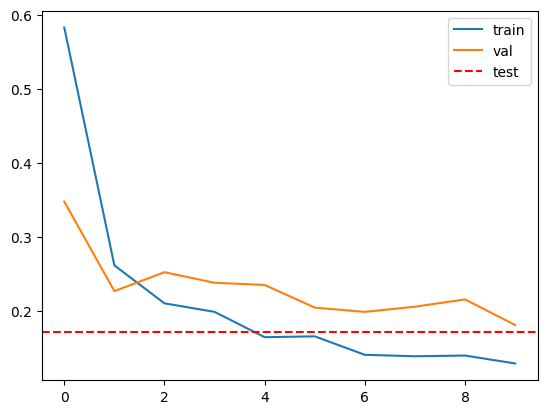

In [7]:
EPOCHS = 10 # 00
N_VAL_ATTEMPTS = 5
LR = 1e-2

loss_fn = nn.MSELoss()
best_val_loss = float('inf')

val_failures = 0
model = init_regressor().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.1, )

losses = []
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids, labels = batch
        input_ids, labels = input_ids.to(DEVICE), labels.to(DEVICE)
        outputs = model(input_ids).squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    val_loss = get_val_loss(model, val_dataloader, loss_fn)
    print(f'Epoch {epoch} train loss: {train_loss / len(train_dataloader)}')
    print(f'Epoch {epoch} val loss: {val_loss}')
    losses.append((train_loss / len(train_dataloader), val_loss))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        val_failures = 0
    else:
        val_failures += 1
        if val_failures >= N_VAL_ATTEMPTS:
            break

# make a plot of the training and validation losses
train_losses, val_losses = zip(*losses)
test_loss = get_val_loss(model, test_dataloader, loss_fn)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.axhline(test_loss, color='r', linestyle='--', label='test')
plt.legend()

In [8]:
def get_correlation(model, dataloader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, label = batch
            input_ids, label = input_ids.to(DEVICE), label.to(DEVICE)
            outputs = model(input_ids).squeeze()
            preds.append(outputs)
            labels.append(label)
    preds = torch.cat(preds).numpy(force=True)
    labels = torch.cat(labels).numpy(force=True)
    return spearmanr(preds, labels), preds, labels

Train correlation: SignificanceResult(statistic=0.9483712210523262, pvalue=0.0)
Val correlation: SignificanceResult(statistic=0.929291479718479, pvalue=1.0326942966011526e-303)
Test correlation: SignificanceResult(statistic=0.9323018800853181, pvalue=0.0)


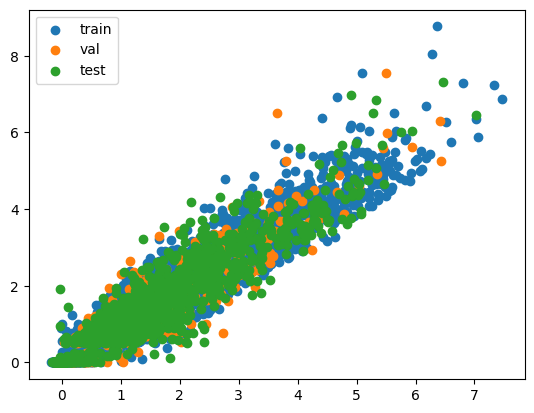

In [9]:
print(f"Train correlation: {get_correlation(model, train_dataloader)[0]}")
print(f"Val correlation: {get_correlation(model, val_dataloader)[0]}")
print(f"Test correlation: {get_correlation(model, test_dataloader)[0]}")
# make plot of 3 different correlations
_, train_preds, train_labels = get_correlation(model, train_dataloader)
_, val_preds, val_labels = get_correlation(model, val_dataloader)
_, test_preds, test_labels = get_correlation(model, test_dataloader)

plt.scatter(train_preds, train_labels, label='train')
plt.scatter(val_preds, val_labels, label='val')
plt.scatter(test_preds, test_labels, label='test')
plt.legend()

In [10]:
# compute influence function of the model
from bio_if.modules.influence import influence, get_ekfac_factors_and_pseudo_grads

In [11]:
# turn train dataset into a list
train_list = list(train)
test_list = list(test)

# "tokenize" the first value of each tuple
train_list = [(tokenizer_fn(x).reshape(1, -1), y) for x, y in train_list]
test_list = [(tokenizer_fn(x).reshape(1, -1), y) for x, y in test_list]

In [18]:
influences = influence(
    model,
    list(model),
    test_list,
    train_list,
    train_list,
    DEVICE,
    torch.nn.functional.mse_loss, aggregate_query_grads=True
)

Computing EKFAC factors and pseudo gradients


  0%|          | 0/6289 [00:00<?, ?it/s]/home/cadegord/projects/bio-if/src/bio_if/modules/influence.py:61: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(output, target)
100%|██████████| 6289/6289 [00:31<00:00, 202.17it/s]


Computing search gradients


  0%|          | 0/6289 [00:00<?, ?it/s]/home/cadegord/projects/bio-if/src/bio_if/modules/influence.py:96: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(output, target)
100%|██████████| 6289/6289 [00:26<00:00, 236.73it/s]


Computing iHVP


100%|██████████| 1/1 [00:00<00:00, 228.93it/s]


In [16]:
import seaborn as sns
import numpy as np

In [53]:
# sort influences and take top 1 percent
influences_sorted = torch.sort(influences).values.numpy(force=True)
n = len(influences_sorted)
top_1_percent = influences_sorted[int(n * 0.99):]
n_top_1 = len(top_1_percent)
# cdf: y = 1 - (x / x_min) ** -alpha
# 1-y = (x / x_min) ** -alpha
# log(1-y) = -alpha * log(x / x_min)
# fit a power law to the top 1 percent
# fit ridge regression to the above equation
log_y = np.log(1-np.linspace(0.99, 1, n_top_1, endpoint=False))
log_y_mean = log_y.mean()
log_x = np.log(top_1_percent) - np.log(top_1_percent.min())
log_x_mean = log_x.mean()
alpha = -np.sum((log_x - log_x_mean) * (log_y - log_y_mean)) / np.sum((log_x - log_x_mean) ** 2)
print(f'alpha: {alpha}')

alpha: 2.3342674892071202


0.00011755652345862647
73.598236 6.7097473 -2.3342674892071202 -0.0009534093311566083


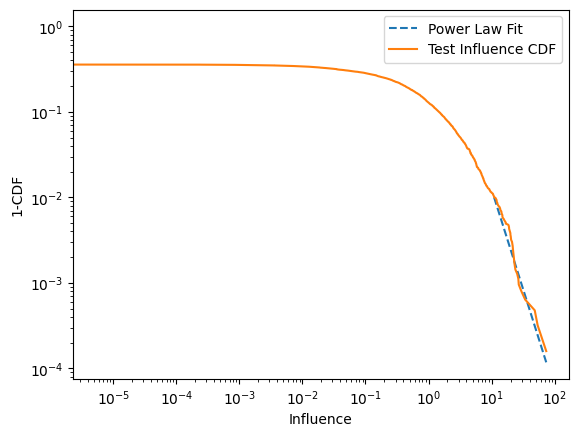

In [71]:
complementary_cdf = 1-np.linspace(0, 1, n, endpoint=False)
# plot a power law to the top 1 percent
# v = (top_1_percent[-1]/top_1_percent[0])**-alpha
m = top_1_percent[0]
v = np.exp(np.log(0.01)-alpha * (np.log(top_1_percent[-1]/m) - np.log(top_1_percent[0]/m)))
print(v)
plt.plot((top_1_percent[0], top_1_percent[-1]), (0.01, v), label='Power Law Fit', linestyle='--')
print(top_1_percent[-1], top_1_percent[-1]/top_1_percent[0], -alpha, (complementary_cdf[-1]-0.01)*np.exp(-alpha))
# sns.lineplot([top_1_percent[0], top_1_percent[-1]], [0.01, 0], label='Power Law Fit')

# plot a CDF of the influences
plt.plot(influences_sorted, complementary_cdf, label='Test Influence CDF')
plt.xlabel('Influence')
plt.ylabel('1-CDF')
# make the plot log-log
plt.xscale('log')
plt.yscale('log')
plt.legend()